# Air Temperature Model Fitting and Evaluation

This notebook focuses on fitting the Air Temperature Estimation Model with input from the LCZ Identification Model.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from model_functions import *

import ee
import geemap
from gee_functions import * # custom functions for GEE
from settings import * # global variables for GEE data download

from IPython.display import Image
import folium

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import requests

import pickle
import dill

2023-05-24 09:40:51.508929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%load_ext autoreload
%autoreload 2

----

## Load Dataset

In [4]:
train_df = pickle.load(open('../datasets/airtemp_train_full.pkl', 'rb'))

----

## Quick EDA

In [18]:
# define style of plots
rc_params = {'axes.facecolor': '#00002E', 'axes.edgecolor': 'white',
             'figure.facecolor':'#00002E', 'axes.labelcolor': 'white',
             'xtick.color':'white', 'ytick.color':'white', 
             'axes.spines.right': False, 'axes.spines.top': False}
sns.set_style(rc = rc_params)


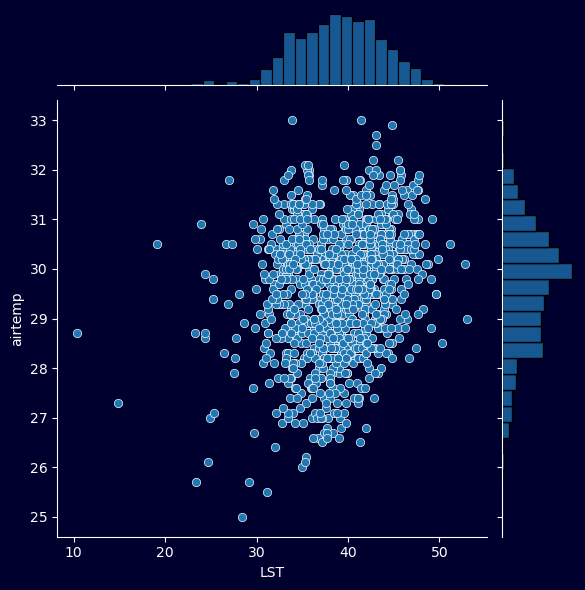

In [19]:
# look at LST vs airtemp
sns.jointplot(data=train_df, x='LST', y='airtemp');

Observation:

- Any LST above 70degC is probably an errorneous reading, hence we have dropped those
- Of the remaining datapoint, we note that there is a positive correlation visually

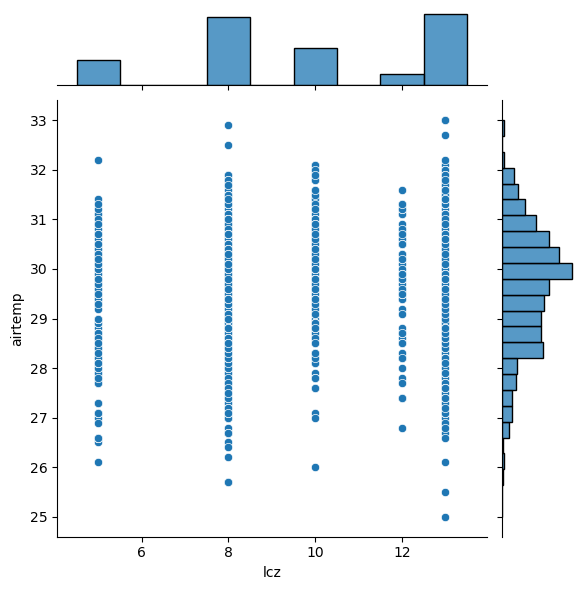

In [23]:
# look at lcz vs airtemp
sns.jointplot(data=train_df, x='lcz', y='airtemp');

Observation:

- LCZ alone cannot tell much, but we note that there are only 5 LCZs identified from the training dataset
- This will severely limit the usefulness of LCZ in estimating air temp in other parts of Singapore

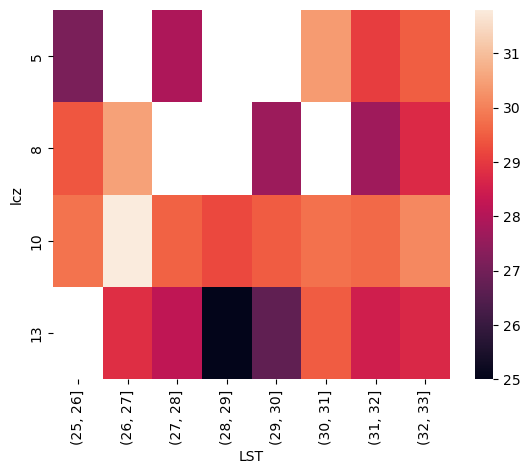

In [32]:
# look at heatmap of lcz-LST v airtemp
sns.heatmap(pd.crosstab(index=train_df['lcz'], 
                        columns=pd.cut(train_df['LST'], list(range(25,34))), 
                        values=train_df['airtemp'], aggfunc='mean'));

----

## Data Preprocessing

In [5]:
# drop NA values
train_df.dropna(inplace=True)

In [6]:
# drop erroneous LST values
train_df = train_df[train_df['LST']<70.]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1075 entries, 0 to 1246
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         1075 non-null   int64         
 1   datetime      1075 non-null   datetime64[ns]
 2   longitude     1075 non-null   float64       
 3   latitude      1075 non-null   float64       
 4   LST           1075 non-null   float64       
 5   image         1075 non-null   object        
 6   airtemp       1075 non-null   float64       
 7   id            1075 non-null   object        
 8   y_pred_proba  1075 non-null   object        
 9   lcz           1075 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 85.1+ KB


In [13]:
train_df['lcz'].value_counts()

13    361
8     343
10    187
5     125
12     59
Name: lcz, dtype: int64

In [9]:
# create X and y
X = train_df[['LST', 'lcz']]
y = train_df['airtemp']

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=X['lcz'])

----

## Model Fitting

### Baseline Model

We define the baseline model as the simple linear regressor model using only LST as a predictor to air temperature

In [10]:
# Preprocessing
preproc_baseline = ColumnTransformer([('identity', identity_transformer, ['LST'])])

In [11]:
# Model Building
model_baseline = Pipeline(
    steps = [
        ('preproc', preproc_baseline),
        ('model', LinearRegression())
    ]
)

In [12]:
# fit model
model_baseline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('identity',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7f8d9562a710>),
                                                  ['LST'])])),
                ('model', LinearRegression())])

In [13]:
# check model performance
model_performance(model_baseline, X_train, X_test, y_train, y_test)

----------Mean Absolute Error----------
MAE Train: 0.96
MAE Test: 0.97
--------Root Mean Squared Error--------
RMSE Train: 1.20
RMSE Test: 1.22


### Model A - Linear Regression with LCZ

We try out fitting a linear model with LST and LCZ

In [14]:
# Preprocessing
preproc_A = ColumnTransformer([
    ('identity', identity_transformer, ['LST']),
    ('onehot', onehot_transformer, ['lcz'])
])

In [15]:
# Model Building
model_A = Pipeline(
    steps = [
        ('preproc', preproc_A),
        ('model', LinearRegression())
    ]
)

In [16]:
# fit model
model_A.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('identity',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7f8d9562a710>),
                                                  ['LST']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lcz'])])),
                ('model', LinearRegression())])

In [17]:
# check model performance
model_performance(model_A, X_train, X_test, y_train, y_test)

----------Mean Absolute Error----------
MAE Train: 0.91
MAE Test: 0.94
--------Root Mean Squared Error--------
RMSE Train: 1.15
RMSE Test: 1.17


Observation:

- We note that LCZ marginally improves performance

### Model B - Random Forest Regressor with LCZ

We try out fitting a RF model with LST and LCZ

In [18]:
# Model Building
model_B = Pipeline(
    steps = [
        ('preproc', preproc_A),
        ('model', RandomForestRegressor())
    ]
)

In [19]:
# define hyperparameter search space
rf_params = {
    'model__max_depth': Integer(2, 50),
    'model__min_samples_split': Integer(2, 11),
    'model__min_samples_leaf': Integer(1, 9),
    'model__max_features': Real(0.01, 1)
}

In [20]:
# define Bayesian search object
opt = BayesSearchCV(
    estimator = model_B,
    search_spaces = rf_params,
    scoring = 'neg_root_mean_squared_error',
    cv=3
)


In [21]:
%%time
# run Bayesian search for model
opt.fit(X_train, y_train)

CPU times: user 4min 14s, sys: 7.34 s, total: 4min 21s
Wall time: 1min 31s


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preproc',
                                         ColumnTransformer(transformers=[('identity',
                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                              func=<function <lambda> at 0x7f8d9562a710>),
                                                                          ['LST']),
                                                                         ('onehot',
                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                          ['lcz'])])),
                                        ('model', RandomForestRegressor())]),
              scoring='neg_root_mean_squared_error',
              search_spaces={'model__max_depth': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'model__max_features': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'model__min_samples_leaf': Integer(low=1, high=9, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=11, prior='uniform', transform='normalize')})

In [23]:
# assign best estimator
model_B = opt.best_estimator_

# save model
dill.dump(model_B, open('../models/model_B.sav', 'wb'))

In [24]:
# check model performance
model_performance(model_B, X_train, X_test, y_train, y_test)

----------Mean Absolute Error----------
MAE Train: 0.88
MAE Test: 0.92
--------Root Mean Squared Error--------
RMSE Train: 1.12
RMSE Test: 1.16


### Model C - Support Vector Regressor with LCZ

We try out fitting a SV model with LST and LCZ

In [25]:
# Model Building
model_C = Pipeline(
    steps = [
        ('preproc', preproc_A),
        ('model', SVR())
    ]
)

In [45]:
# define hyperparameter search space
svr_params = {
    'model__kernel': Categorical(['linear', 'rbf']),
    #'model__degree': Integer(2, 5),
    'model__gamma': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__C': Real(1e-4, 1e4, prior='log-uniform')
}


In [57]:
# define Bayesian search object
opt = BayesSearchCV(
    estimator = model_C,
    search_spaces = svr_params,
    scoring = 'neg_root_mean_squared_error',
    cv=3,
    n_jobs=4, n_points=2
)


In [58]:
%%time
# run Bayesian search for model
opt.fit(X_train, y_train)

CPU times: user 2min 27s, sys: 4.07 s, total: 2min 31s
Wall time: 1min 22s


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preproc',
                                         ColumnTransformer(transformers=[('identity',
                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                              func=<function <lambda> at 0x7f8d9562a710>),
                                                                          ['LST']),
                                                                         ('onehot',
                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                          ['lcz'])])),
                                        ('model',
                                         SVR(C=10000.0,
                                             gamma=3.513695016684445e-05))]),
              n_jobs=4, n_points=2, scoring='neg_root_mean_squared_error',
              search_spaces={'model__C': Real(low=0.0001, high=10000.0, prior='log-uniform', transform='normalize'),
                             'model__gamma': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize'),
                             'model__kernel': Categorical(categories=('linear', 'rbf'), prior=None)})

In [59]:
# assign best estimator
model_C = opt.best_estimator_


# save model
dill.dump(model_C, open('../models/model_C.sav', 'wb'))

In [60]:
# check model performance
model_performance(model_C, X_train, X_test, y_train, y_test)

----------Mean Absolute Error----------
MAE Train: 0.91
MAE Test: 0.95
--------Root Mean Squared Error--------
RMSE Train: 1.15
RMSE Test: 1.18


### Model D - XGBoost Regressor with LCZ

We try out fitting a XGBoost model with LST and LCZ

In [30]:
# Model Building
model_D = Pipeline(
    steps = [
        ('preproc', preproc_A),
        ('model', XGBRegressor())
    ]
)

In [31]:
# define hyperparameter search space
xgb_params = {
    'model__n_estimators': Integer(10, 500, prior='log-uniform'),
    'model__max_depth': Integer(2, 50),
    'model__eta': Real(0.001, 0.5, prior='log-uniform'),
    'model__subsample': Real(0.1, 1),
    'model__colsample_bytree': Real(0.1, 1)    
}


In [53]:
# define Bayesian search object
opt = BayesSearchCV(
    estimator = model_D,
    search_spaces = xgb_params,
    scoring = 'neg_root_mean_squared_error',
    cv=3,
    n_jobs=4, n_points=2
)


In [54]:
%%time
# run Bayesian search for model
opt.fit(X_train, y_train)

CPU times: user 2min 46s, sys: 4.32 s, total: 2min 50s
Wall time: 51.5 s


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preproc',
                                         ColumnTransformer(transformers=[('identity',
                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                              func=<function <lambda> at 0x7f8d9562a710>),
                                                                          ['LST']),
                                                                         ('onehot',
                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                          ['lcz'])])),
                                        ('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None...
              search_spaces={'model__colsample_bytree': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
                             'model__eta': Real(low=0.001, high=0.5, prior='log-uniform', transform='normalize'),
                             'model__max_depth': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=10, high=500, prior='log-uniform', transform='normalize'),
                             'model__subsample': Real(low=0.1, high=1, prior='uniform', transform='normalize')})

In [55]:
# assign best estimator
model_D = opt.best_estimator_

# save model
dill.dump(model_D, open('../models/model_D.sav', 'wb'))

In [56]:
# check model performance
model_performance(model_D, X_train, X_test, y_train, y_test)

----------Mean Absolute Error----------
MAE Train: 0.87
MAE Test: 0.91
--------Root Mean Squared Error--------
RMSE Train: 1.10
RMSE Test: 1.16


----

## Model Evaluation

Comparing the RMSE and MAE of the models below, we note that the XGBoost model performs the best, with a ~10% improvement to RMSE.

| Model | MAE | RMSE |
|-----|-----|:-----:|
| Baseline (Linear Regression with LST) | 0.94 | 1.17 |
| Random Forest (with LST and LCZ) | 0.92 | 1.16 |
| Support Vector (with LST and LCZ) | 0.95 | 1.18 |
| XGBoost (with LST and LCZ) | 0.91 | 1.16 |
